In [1]:
from IPython.core.display import display, HTML # full-width cells
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import and plot data
`cycles.csv` labels the cycle in which each data point belongs.

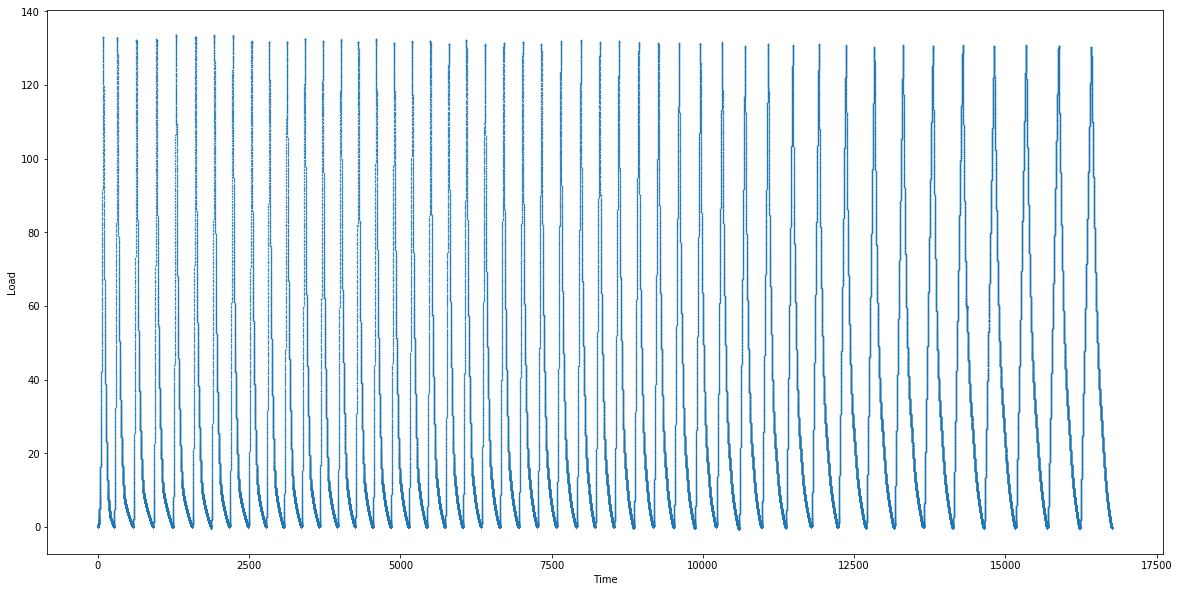

In [3]:
df = pd.read_csv('data/cycles.csv')
fig, axes = plt.subplots(figsize=(20,10))
sns.set()
sns.set_style('whitegrid')
sns.regplot('Time', 'Load', df, fit_reg=False, scatter_kws={'s': 2});

### Extrema behavior over time
Plots of minimum and maximum force (N) over all cycles.

In [4]:
from scipy.signal import argrelextrema
import statsmodels
pd.options.mode.chained_assignment = None  # ignore SettingWithCopyWarning

In [5]:
# TODO clean this up
minima_ind = argrelextrema(df['Load'].values, comparator=np.less, order=100)[0]
maxima_ind = argrelextrema(df['Load'].values, comparator=np.greater, order=100)[0]
time = pd.DataFrame(df['Time'].values[minima_ind]); time.columns = ['Time']
minima = pd.DataFrame(df['Load'].values[minima_ind]); minima.columns = ['MinLoad']; minima = time.join(minima)
maxima = pd.DataFrame(df['Load'].values[maxima_ind]); maxima.columns = ['MaxLoad']; maxima = time.join(maxima)

We choose robust OLS to ignore the maxima outlier at `Time=~1500`.

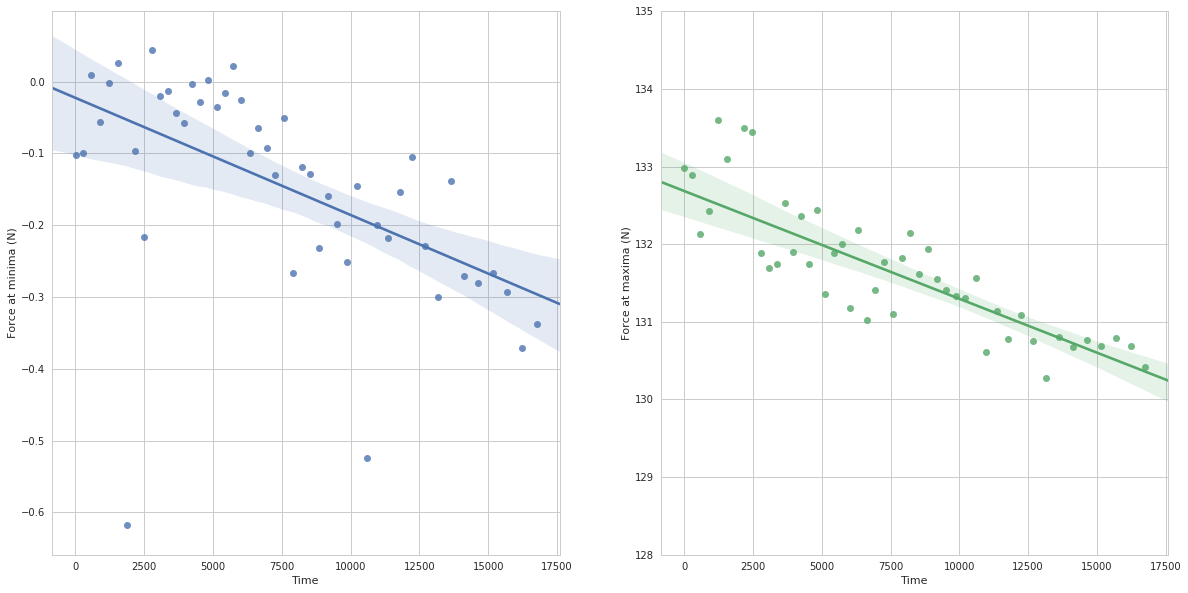

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
sns.regplot('Time', 'MinLoad', minima, ax=axes.flat[0]); axes[0].set(ylabel='Force at minima (N)')
axes.flat[1].set_ylim(128, 135)
sns.regplot('Time', 'MaxLoad', maxima, robust=True, ax=axes.flat[1]); axes[1].set(ylabel='Force at maxima (N)');

### Cycles overlaid over time

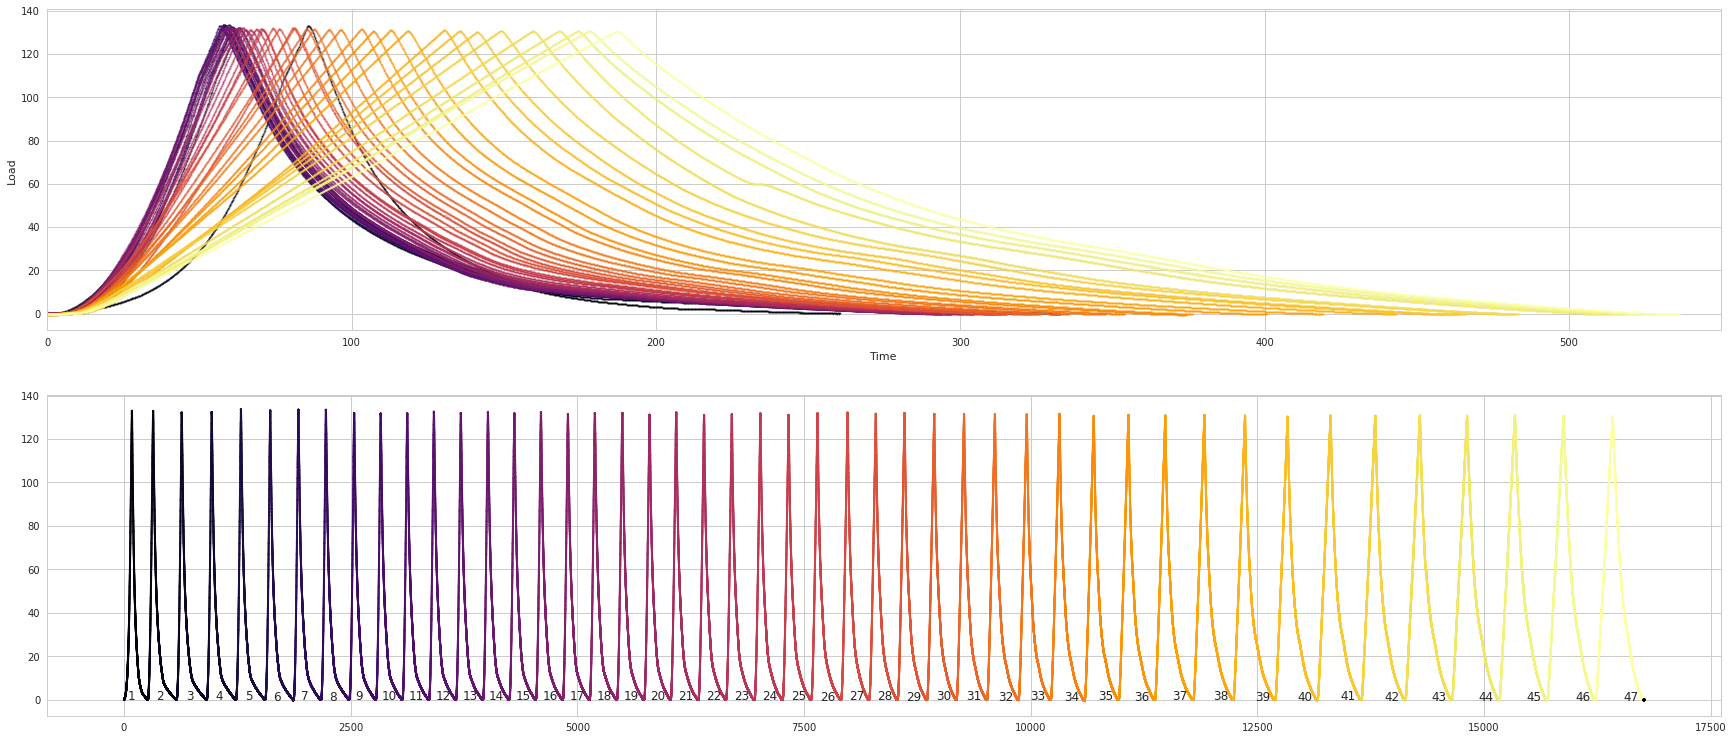

In [7]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(30,13)); axes.flat[0].set_xlim(0, 550)
cmap = plt.get_cmap('inferno') #axes.set_color_cycle(['red', 'black', 'yellow'])
colors = [cmap(i) for i in np.linspace(0, 1, df.Cycle.max())]
for cycle in range(df.Cycle.max()):
    zeroed_df = df[df.Cycle==cycle]
    zeroed_df.Time -= zeroed_df.Time.min() #zeroed_df.reset_index(drop=True, inplace=True)
    sns.regplot('Time', 'Load', zeroed_df, fit_reg=False, scatter=True, ax=axes.flat[0], scatter_kws={'s': 3, 'color': colors[cycle], 'alpha': 0.5})
axes.flat[1].scatter(df.Time, df.Load, s=3, c=df.Cycle, cmap=cmap);
for i, row in minima.iterrows():
    if i > 0:
        axes.flat[1].text(row['Time']-220, row['MinLoad'], str(i)) # hack to label cycles at bottom
#df.apply(lambda row: axes.flat[0].text(row.Time, row.Load, '%.1f'%(row.Cycle)),axis=1);

### Area under cycle curve, over time
We plot an OLS regression line for reference.

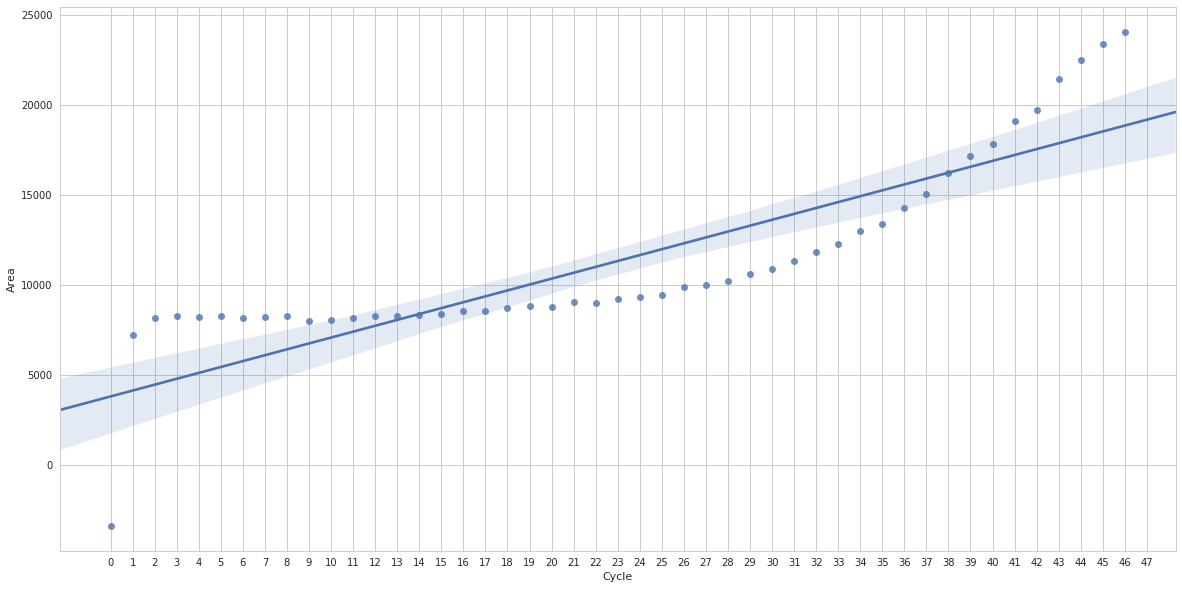

In [8]:
fig, axes = plt.subplots(figsize=(20,10))#; axes.flat[0].set_xlim(0, 550)
areas = np.zeros((df.Cycle.max(),))
for cycle in range(df.Cycle.max()):
    cycle_load = df[df.Cycle==cycle].Load.as_matrix()
    cycle_time = df[df.Cycle==cycle].Time.as_matrix()
    areas[cycle] = np.trapz(cycle_load, cycle_time)
areas_df = pd.DataFrame(areas); areas_df.columns = ['Area']; areas_df = areas_df.reset_index()
sns.regplot('index', 'Area', areas_df)
axes.set_xticks(np.arange(0, 48)); axes.set(xlabel='Cycle');

### Moment of area over time
We determine both 1st and 2nd moments of area.

In [9]:
from scipy.stats import moment

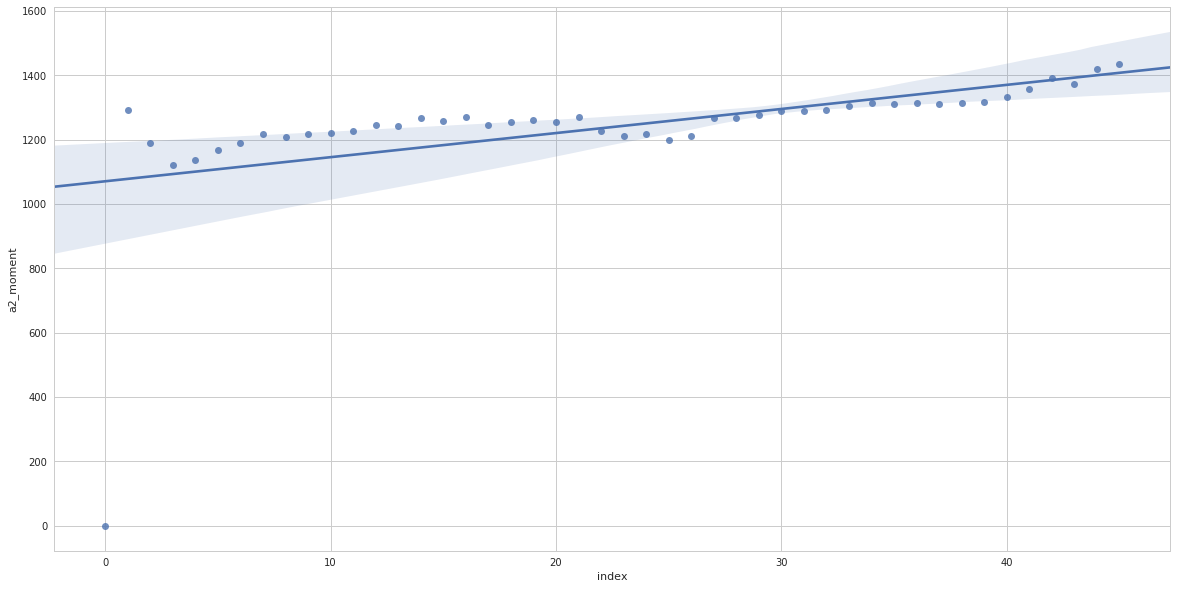

In [10]:
fig, axes = plt.subplots(figsize=(20,10))#; axes.flat[0].set_xlim(0, 550)
moments = np.zeros((df.Cycle.max()-1, 2))
for cycle in range(df.Cycle.max()-1):
    moments[cycle] = moment(df[df.Cycle==cycle].iloc[1:,:2].as_matrix(), moment=2)
moments_df = pd.DataFrame(moments); moments_df.columns = ['a1_moment', 'a2_moment']; moments_df = moments_df.reset_index()
sns.regplot('index', 'a2_moment', moments_df);

In [11]:
### TODO: Curve belly area, heating/cooling time, mean of points/curve, variance of points/curve

### Push minima, maxima, area, moment of area to a new dataset

In [12]:
area_df = pd.DataFrame(areas, columns=['Area'])
moa_df = pd.DataFrame(areas, columns=['Moment'])
meta_df = minima.merge(maxima, on='Time')
meta_df = meta_df.join(area_df).join(moa_df)
meta_df.drop(axis=0, index=0); # Ignore the Instron initialization cycle at t=1.7s

In [13]:
norm_meta_df = meta_df
for index, row in meta_df.iterrows():
    if index > 0:
        norm_meta_df.iloc[index]['Time'] -= meta_df.iloc[index-1,:]['Time']

### Covariance matrix for new features
As visible in the new features (`meta_df`), area increases with time.

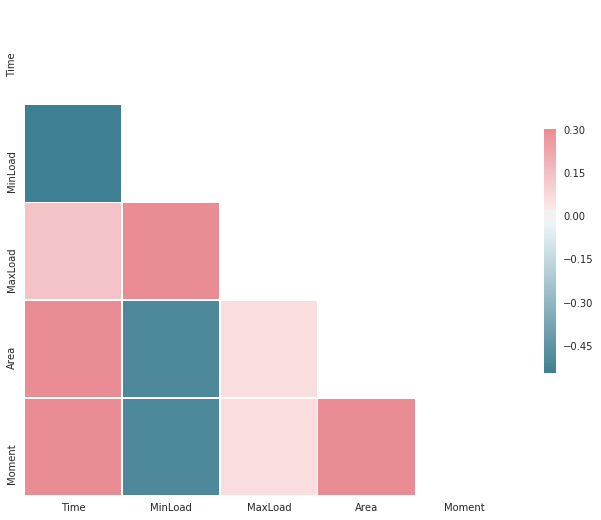

In [14]:
fig, axes = plt.subplots(figsize=(11, 9))
corr = norm_meta_df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [15]:
tdf = df.set_index(pd.to_datetime(df['Time'].as_matrix(), unit='s', infer_datetime_format=True)).drop(columns=['Time'])
tdf.drop(tdf.index[[0,1]], inplace=True)
tdf = tdf[~tdf.index.duplicated(keep='first')]

In [16]:
from pandas.tseries.offsets import *
pd.timedelta_range(0, periods=(tdf.shape[0]/0.1), freq='S')

TimedeltaIndex([ '0 days 00:00:00',  '0 days 00:00:01',  '0 days 00:00:02',
                 '0 days 00:00:03',  '0 days 00:00:04',  '0 days 00:00:05',
                 '0 days 00:00:06',  '0 days 00:00:07',  '0 days 00:00:08',
                 '0 days 00:00:09',
                ...
                '19 days 16:27:20', '19 days 16:27:21', '19 days 16:27:22',
                '19 days 16:27:23', '19 days 16:27:24', '19 days 16:27:25',
                '19 days 16:27:26', '19 days 16:27:27', '19 days 16:27:28',
                '19 days 16:27:29'],
               dtype='timedelta64[ns]', length=1700850, freq='S')

In [17]:
tdf
#fig, axes = plt.subplots(figsize=(30,8))
#onesec = tdf.asfreq(freq='10s')
#onesec

,Load,Cycle
1970-01-01 00:00:00.100,0.05453,0
1970-01-01 00:00:00.200,0.00621,0
1970-01-01 00:00:00.300,0.00352,0
1970-01-01 00:00:00.400,0.02063,0
1970-01-01 00:00:00.500,-0.00168,0
1970-01-01 00:00:00.600,-0.01183,0
1970-01-01 00:00:00.700,-0.00167,0
1970-01-01 00:00:00.800,-0.00656,0
1970-01-01 00:00:00.900,-0.02108,0
1970-01-01 00:00:01.000,-0.03623,0


### curve belly, heating/cooling time, heating/cooling proportion wrt area under curve, PCA over raw data?

In [18]:
from sklearn.decomposition import PCA

(2658, 2)
[0.84487219 0.15512781]
(3168, 2)
[0.92667676 0.07332324]
(3380, 2)
[0.932879 0.067121]
(3304, 2)
[0.92994536 0.07005464]
(3290, 2)
[0.93091714 0.06908286]
(3136, 2)
[0.92391995 0.07608005]
(3104, 2)
[0.91685215 0.08314785]
(3141, 2)
[0.92143206 0.07856794]
(2980, 2)
[0.90799979 0.09200021]


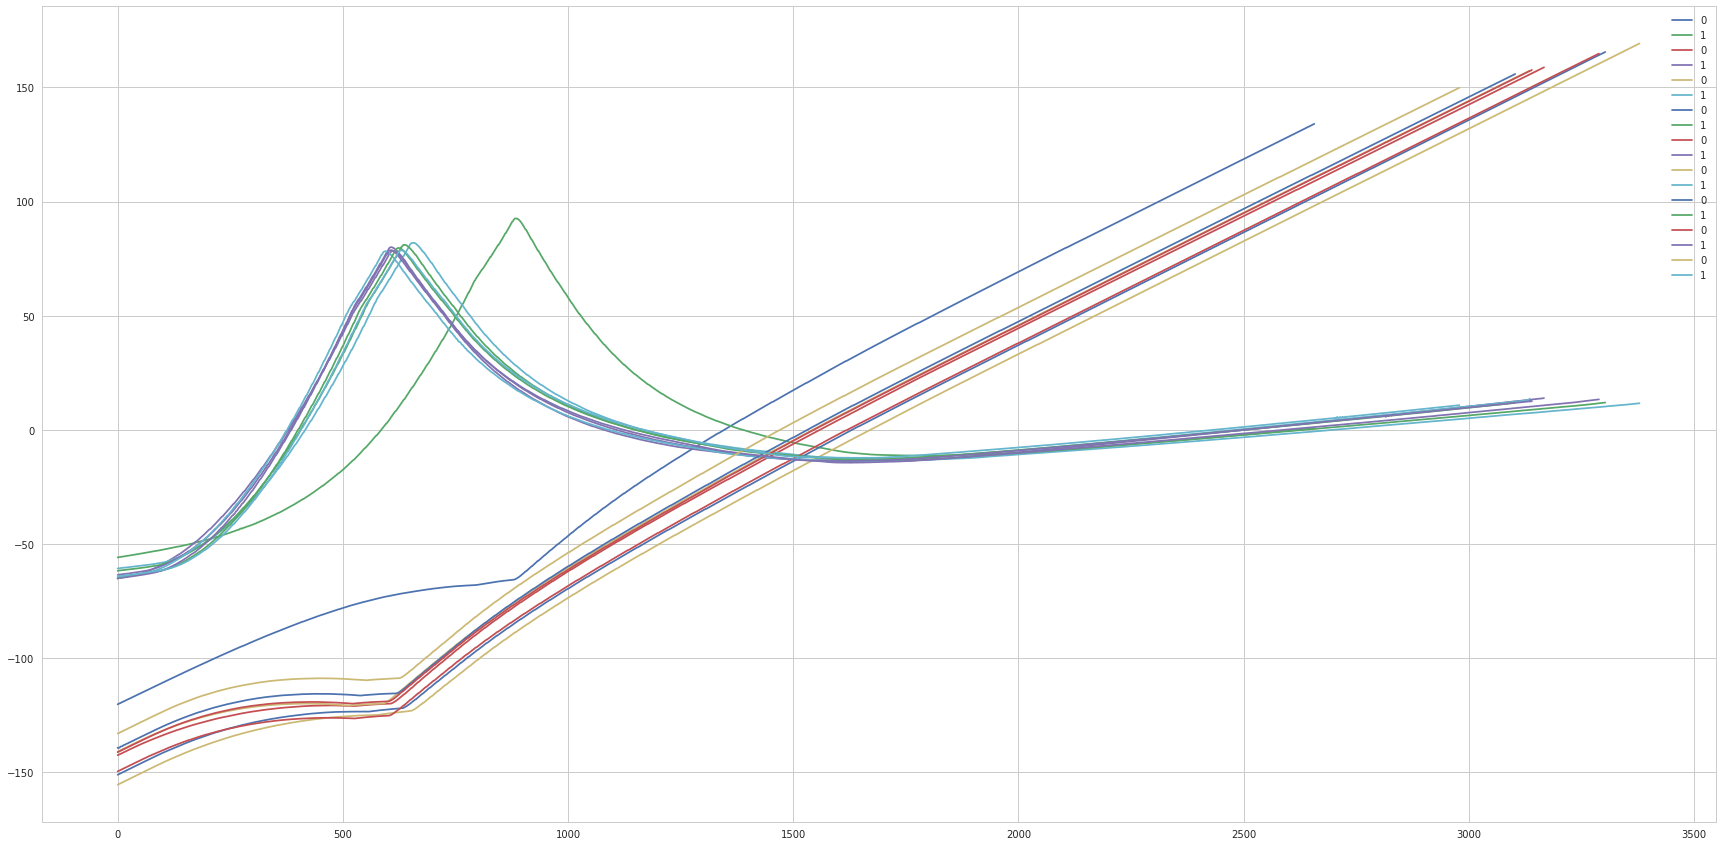

In [27]:
fig, axes = plt.subplots(figsize=(30,15))
pca = PCA(n_components=2)
for cycle in range(1, 10):
    pca_result = pca.fit_transform(df[df.Cycle==cycle])
    pca_result = pd.DataFrame(pca_result)
    print(pca_result.shape)
    pca_result.plot(ax=axes)
    print(pca.explained_variance_ratio_)